In [1]:
from Bio.Align import substitution_matrices
import numpy as np
import pandas as pd

# --------------------------------------------------
# Load BLOSUM62 matrix
# --------------------------------------------------
blosum62 = substitution_matrices.load("BLOSUM62")

AA = list(blosum62.alphabet)

# --------------------------------------------------
# Frankild et al. (2008) EXACT FORMULA
# --------------------------------------------------
def frankild_similarity(x, y):
    """
    Frankild et al. peptide similarity S(x,y):
    1) A(x,y)   = sum W(x_i, y_i)
    2) A_x_max  = A(x,x)
    3) A_x_min  = sum_i min_a W(x_i, a)
    4) S(x,y)   = (A(x,y) - A_x_min) / (A_x_max - A_x_min)
       Asymmetric: S(x,y) != S(y,x)
    Here x = reference (BKV), y = candidate (JCV).
    """
    if len(x) != len(y):
        return np.nan

    # A(x,y)
    A_xy = sum(blosum62[a.upper(), b.upper()] for a, b in zip(x, y))

    # A_x_max = A(x,x)
    A_x_max = sum(blosum62[a.upper(), a.upper()] for a in x)

    # A_x_min = worst substitution per position in x
    A_x_min = 0
    for a in x:
        a = a.upper()
        worst = min(blosum62[a, other] for other in AA)
        A_x_min += worst

    if A_x_max == A_x_min:
        return 1.0
    return (A_xy - A_x_min) / (A_x_max - A_x_min)

# --------------------------------------------------
# BKV & JCV epitopes
# --------------------------------------------------
bkv_epitopes = [
    "MLTERFNHIL", "KLCTFSFLI", "TLACFAVYT", "SLQNSEFLL", "VVFEDVKGT",
    "RLDSEISMY", "VSWKLITEY", "WSSSEVPTY", "YSALTRDPY", "ACFAVYTTK",
    "AWLHCLLPK", "FLICKGVNK", "GVNKEYLLY", "ILYKKLMEK", "IVFNVPKRR",
    "RTLACFAVY", "SAINNFCQK", "SVKVNLEKK", "AYLRKCKEF", "PYHTIEESI",
    "QYMAGVAWL", "RYWLFKGPI", "VFLLLGMYL", "LLDEQGVGPL", "NLRGFSLKL",
    "STARIPLPNL", "SMELMDLLGL", "FLRKEPLVWI", "VLNREESMEL", "VKNPYPISF",
    "NREESMELMDL", "MELMDLLGL", "SQHSTPPKK", "TPHRHRVSA", "VFLLLGMYLEF",
    "FPLCPDTLY", "FPLCPDTLYC", "VHCPCMLCQL", "EPLVWIDCY", "CYCIDCFTQW",
    "FFAVGGDPLEM", "LLLGMYLEF", "ARIPLPNL", "YCIDCFTQW", "IEESIQGGL",
    "LSLMRKAYL", "LLIKGGVEV", "LLMWEAVTV",
    "FLHCIVFNV", "LLLIWFRPV", "VIFDFLHCI", "AITEVECFL", "LPLMRKAYL",
    "CLLPKMDSV", "AVDTVLAKK", "NLLMWEAVTV"
]

jcv_epitopes = [
    "MLVERFNFLL", "KLCTFSFLI", "TVASFAVYT", "SLSCSEYLL", "VVFEDVKGT",
    "RLDLEISMY", "VSWKLVTQY", "WNSSEVPTY", "YSALCRQPY", "ASFAVYTTK",
    "AWIHCLLPQ", "FLICKGVNK", "GVNKEYLLY", "GVNKEYLFY", "ILYKKLMEK",
    "IVLNIPKKR", "RTVASFAVY", "SAINNYCQK", "SVKVNLERK", "AYLKKCKEL",
    "PYAVVEESI", "QYMAGVAWI", "RYWLFKGPI", "VFLLMGMYL", "LLDEFGVGPL",
    "SMELMDLLGL", "FLRSSPLVWI", "VLNREESMEL", "VKNPYPISF", "NREESMELMDL",
    "MELMDLLGL", "SQHSTPPKK", "TPHRHRVSA", "VFLLMGMYLDF", "FPPNSDTLY",
    "FPPNSDTLYC", "VHCPCLMCML", "SPLVWIDCY", "CYCFDCFRQW", "LLMGMYLDF",
    "ARIPLPNL", "YCFDCFRQW", "VEESIQGGL", "NIPVMRKAY", "LLIRGGVEV", "ILMWEAVTL",
    "FLKCIVLNI", "LLLIWFRPV", "LLLIWFKPV", "VIYDFLKCI", "VIYEFLKCI",
    "SITEVECFL", "IPVMRKAYL", "CLLPQMDTV", "AVDTVAAKQ", "NILMWEAVTL",
    "SLMNVHSNG"
]

# --------------------------------------------------
# Analysis (1–3 mismatches only; BKV as reference x)
# --------------------------------------------------
ALLOWED_MISMATCHES = {1, 2, 3}
results = []

print("Computing Frankild et al. (2008) peptide similarity S(BKV,JCV)...")

for bkv in bkv_epitopes:
    for jcv in jcv_epitopes:
        if len(bkv) == len(jcv):
            mismatches = sum(a != b for a, b in zip(bkv, jcv))
            if mismatches in ALLOWED_MISMATCHES:
                score = frankild_similarity(bkv, jcv)  # x = BKV, y = JCV

                if score >= 0.90:
                    category = "HIGH"
                elif score >= 0.80:
                    category = "MODERATE"
                else:
                    category = "LOW"

                results.append({
                    "BKV": bkv,
                    "JCV": jcv,
                    "Length": len(bkv),
                    "Mismatches": mismatches,
                    "Frankild_S_BKV_ref": round(score, 3),
                    "Category": category
                })

# --------------------------------------------------
# Results
# --------------------------------------------------
df = pd.DataFrame(results)
print("\n=== BKV–JCV CROSS-REACTIVITY (Frankild et al. 2008; BKV as reference) ===\n")

if df.empty:
    print("No 1–3 mismatch pairs found.")
else:
    high = df[df["Frankild_S_BKV_ref"] >= 0.90].sort_values("Frankild_S_BKV_ref", ascending=False)
    moderate = df[(df["Frankild_S_BKV_ref"] >= 0.80) & (df["Frankild_S_BKV_ref"] < 0.90)]
    low = df[df["Frankild_S_BKV_ref"] < 0.80]

    print("HIGH (≥0.90):")
    print(high.to_string(index=False))
    print("\nMODERATE (0.80–0.89):")
    print(moderate.to_string(index=False))
    print("\nLOW (<0.80):")
    print(low.to_string(index=False))

    total_pairs = len(df)
    high_count = len(high)
    print(f"\nSUMMARY: {high_count}/{total_pairs} ({high_count/total_pairs*100:.1f}%) high similarity")

print("\n*** EXACT FRANKILD ET AL. (2008) FORMULA ***")
print("S(x,y) = [A(x,y) - A_x_min] / [A_x_max - A_x_min] with x = BKV reference epitope [web:120]")

Computing Frankild et al. (2008) peptide similarity S(BKV,JCV)...

=== BKV–JCV CROSS-REACTIVITY (Frankild et al. 2008; BKV as reference) ===

HIGH (≥0.90):
        BKV         JCV  Length  Mismatches  Frankild_S_BKV_ref Category
  IEESIQGGL   VEESIQGGL       9           1               0.987     HIGH
  QYMAGVAWL   QYMAGVAWI       9           1               0.977     HIGH
  VFLLLGMYL   VFLLMGMYL       9           1               0.975     HIGH
  WSSSEVPTY   WNSSEVPTY       9           1               0.966     HIGH
  SAINNFCQK   SAINNYCQK       9           1               0.965     HIGH
  LLLIWFRPV   LLLIWFKPV       9           1               0.965     HIGH
  AITEVECFL   SITEVECFL       9           1               0.963     HIGH
  LLIKGGVEV   LLIRGGVEV       9           1               0.962     HIGH
  SVKVNLEKK   SVKVNLERK       9           1               0.962     HIGH
  VSWKLITEY   VSWKLVTQY       9           2               0.953     HIGH
  GVNKEYLLY   GVNKEYLFY       9          

=== FRANKILD et al. (2008) SUMMARY ===
High (≥0.90)            23
Moderate (0.80–0.89)    15
Low (<0.80)              3
Name: Category, dtype: int64
Total 1–3 mismatch pairs: 41


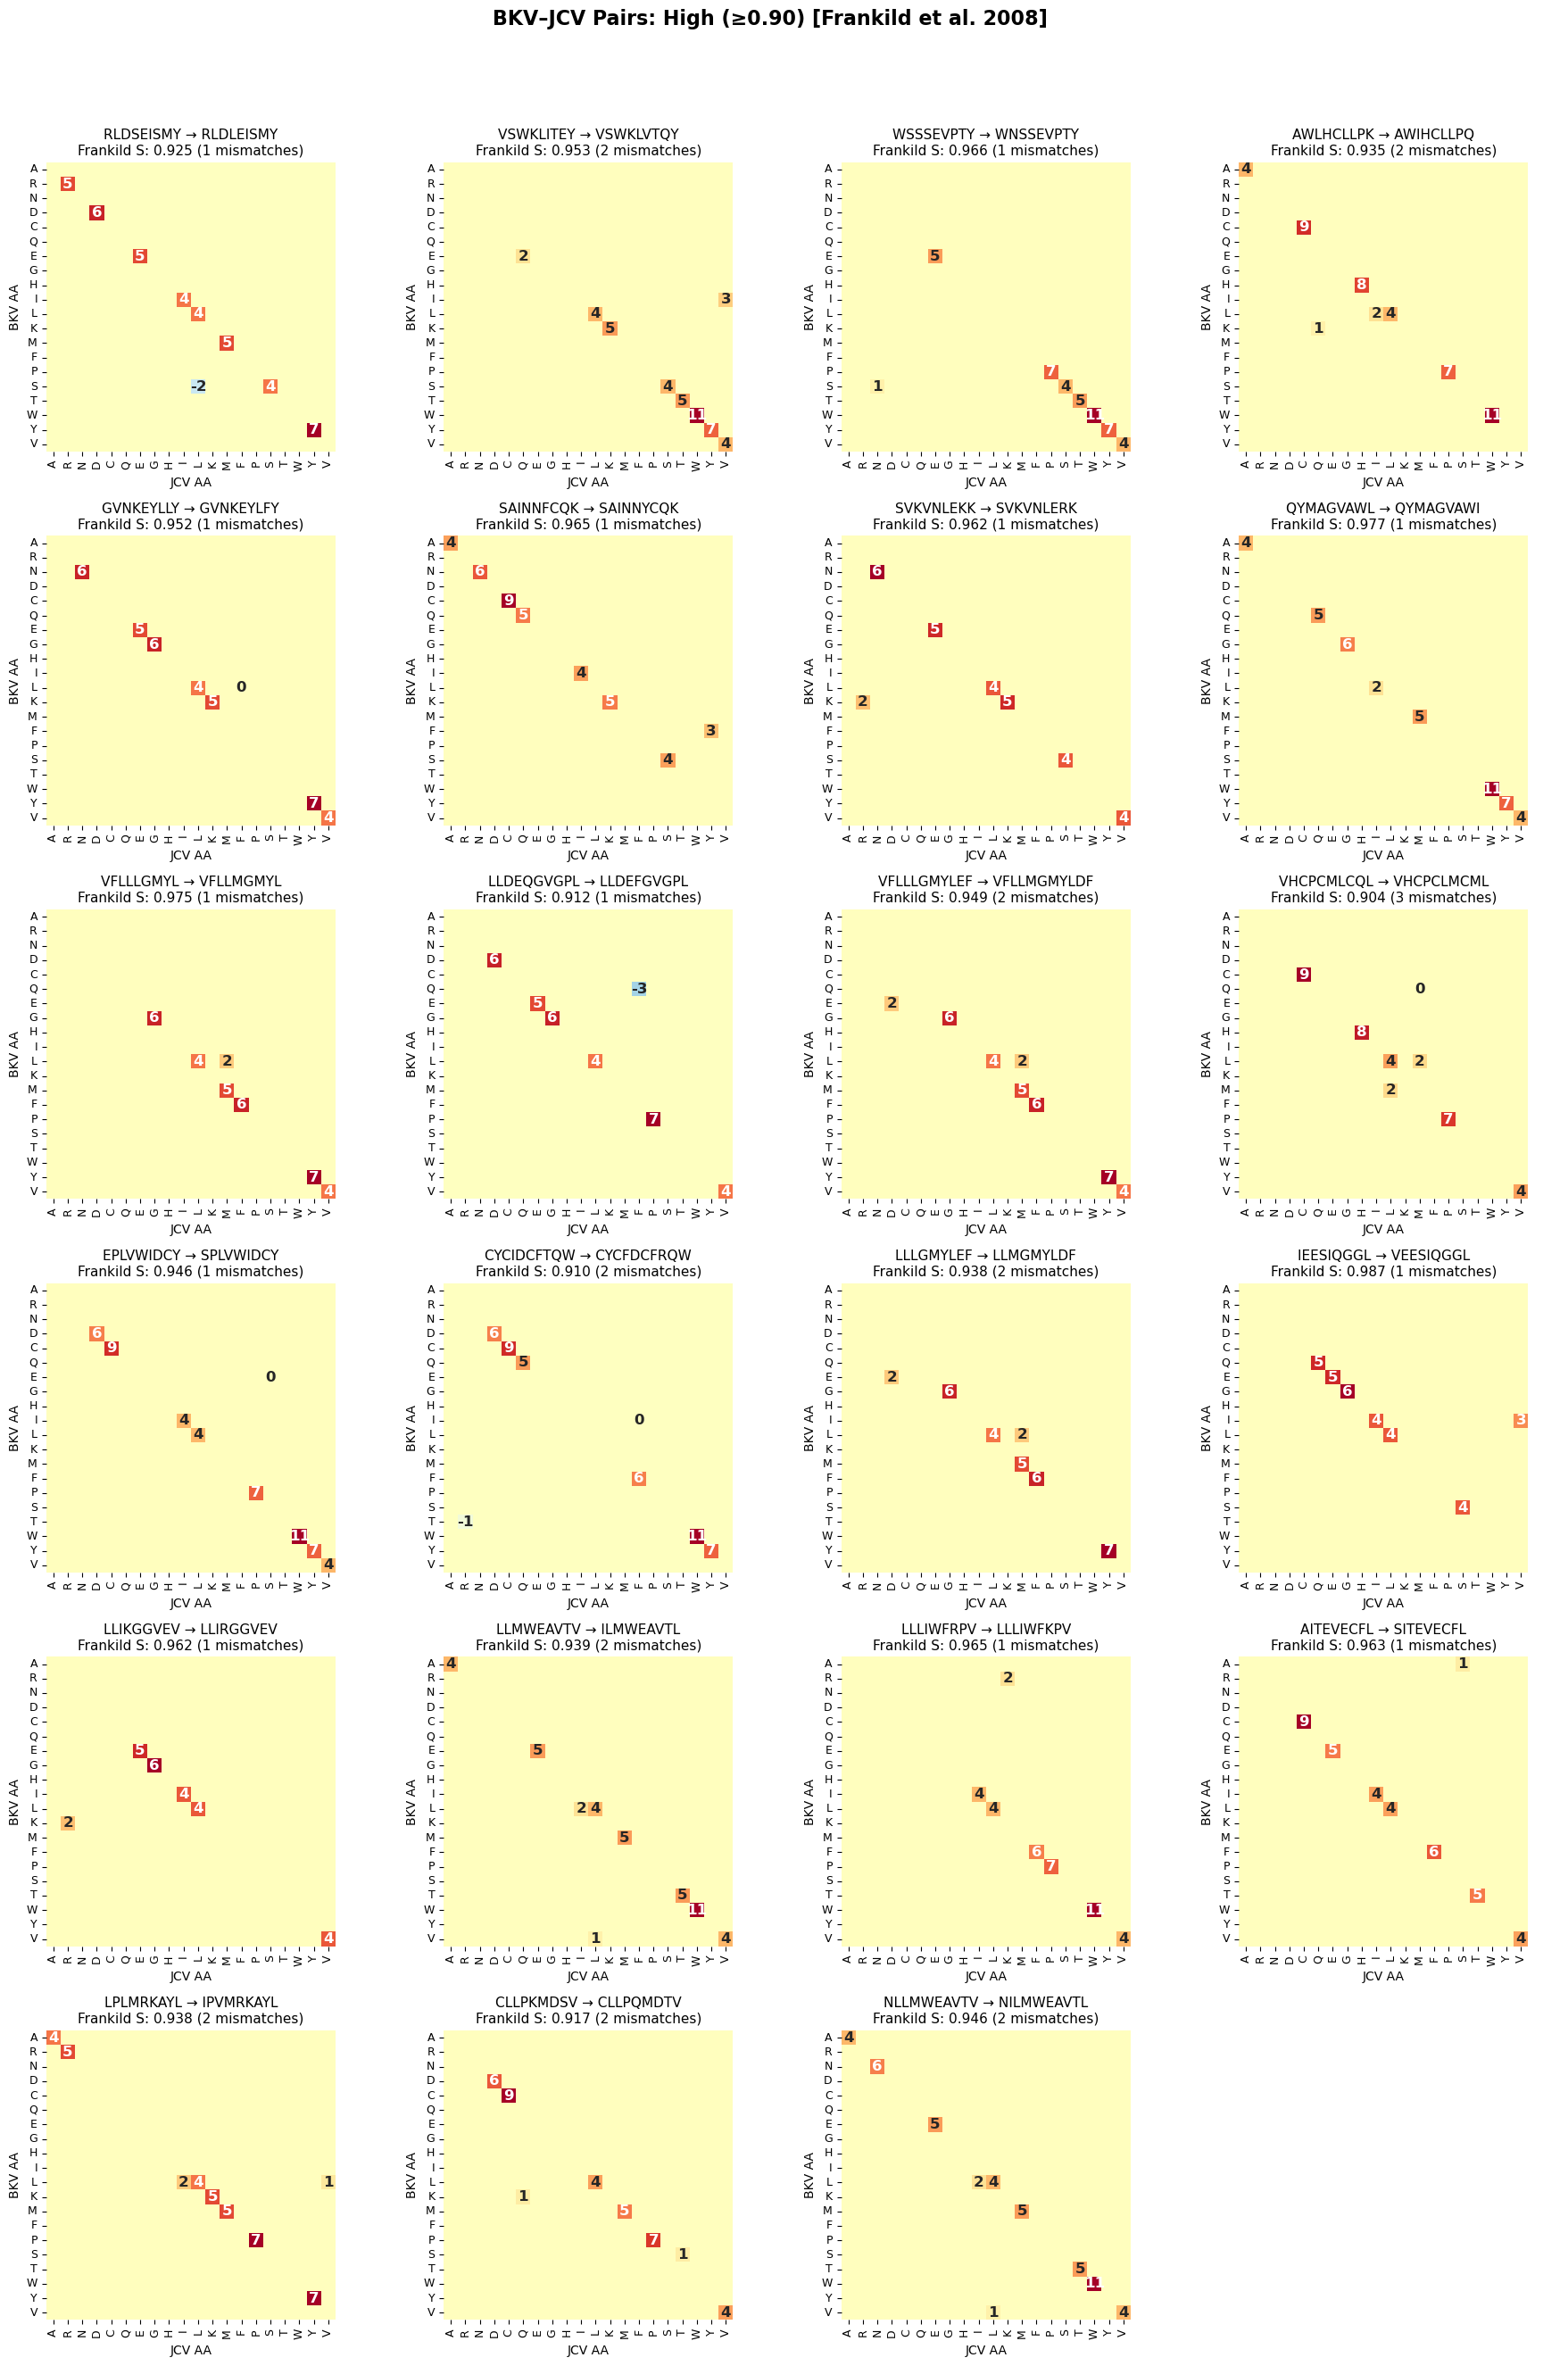

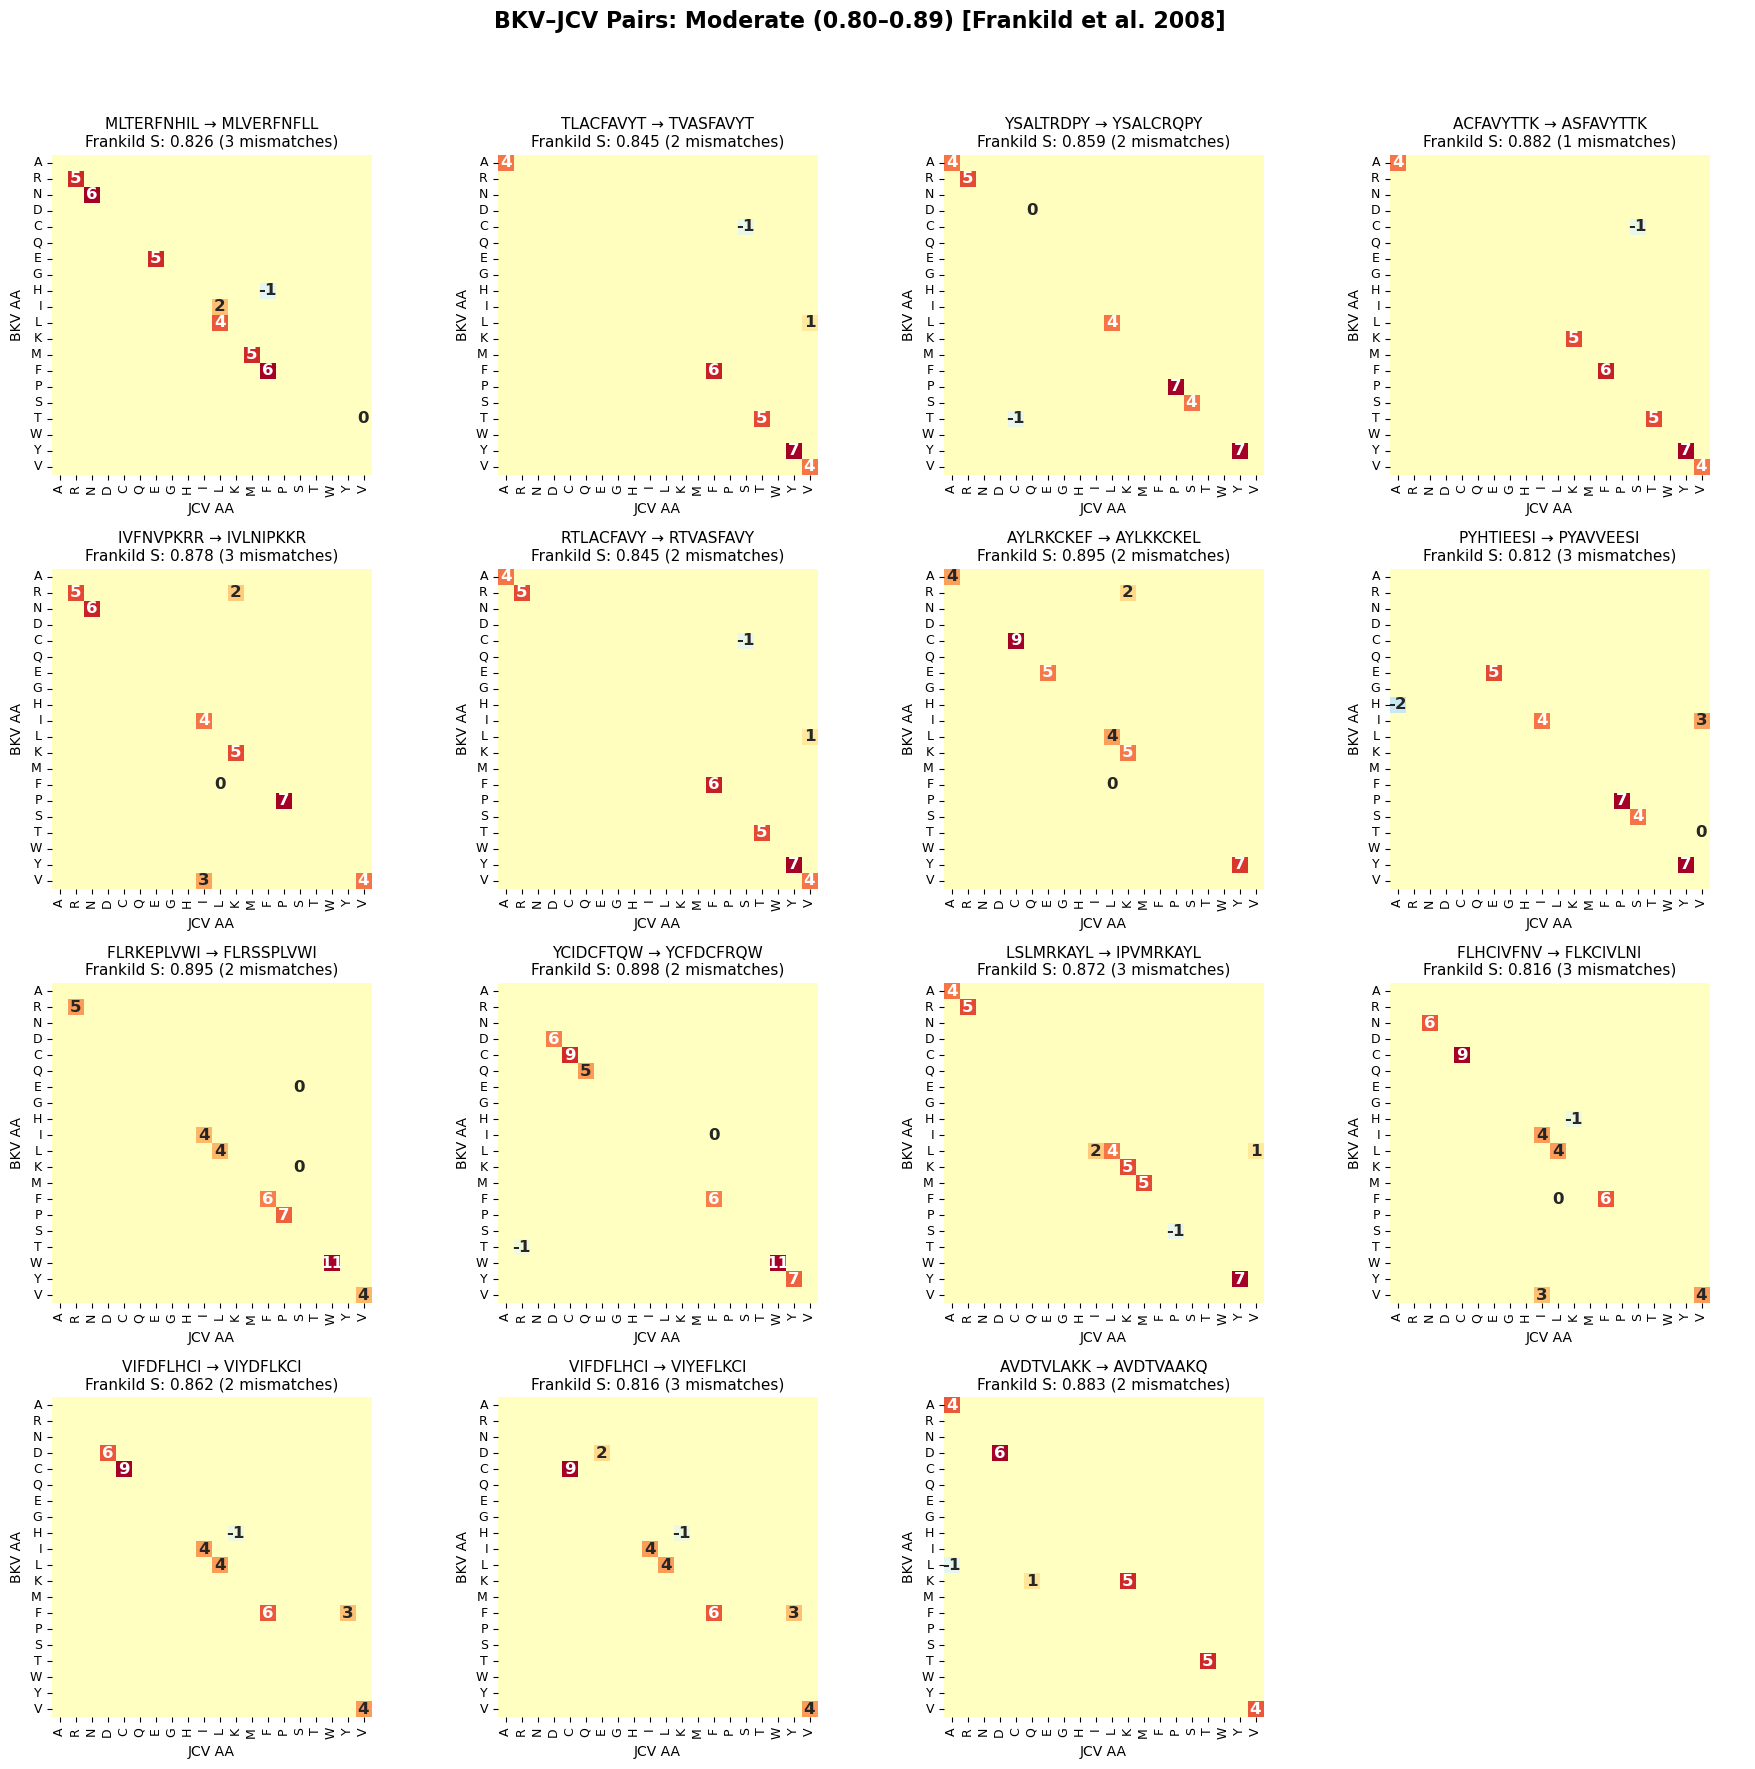

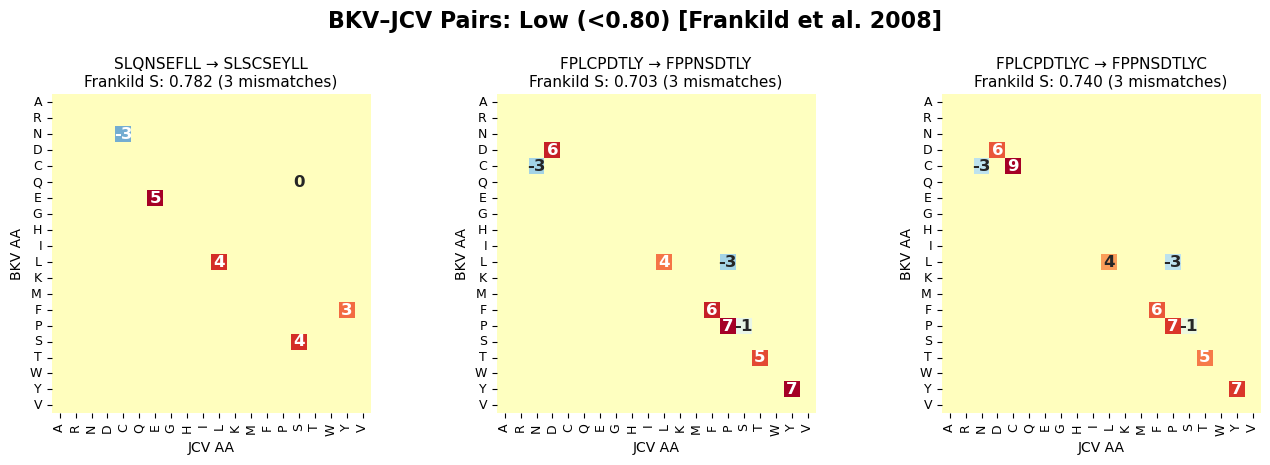

In [2]:
from Bio.Align import substitution_matrices
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import pandas as pd

# =============================== 
# LOAD BLOSUM62
# ===============================
blosum62 = substitution_matrices.load("BLOSUM62")
AA = list(blosum62.alphabet)

# =============================== 
# FRANKILD et al. (2008) SIMILARITY
# ===============================
def frankild_similarity(x, y):
    """
    Frankild et al. (2008) peptide similarity
    S(x,y) = (A(x,y) - A_x_min) / (A_x_max - A_x_min)
    Asymmetric: x = reference (BKV)
    """
    if len(x) != len(y):
        return np.nan

    # A(x,y)
    A_xy = sum(blosum62[a.upper(), b.upper()] for a, b in zip(x, y))

    # A_x_max = A(x,x)
    A_x_max = sum(blosum62[a.upper(), a.upper()] for a in x)

    # A_x_min = worst substitution per position in x
    A_x_min = 0
    for a in x:
        a = a.upper()
        worst = min(blosum62[a, other] for other in AA)
        A_x_min += worst

    if A_x_max == A_x_min:
        return 1.0

    return (A_xy - A_x_min) / (A_x_max - A_x_min)

# =============================== 
# EPITOPE LISTS
# ===============================
bkv_epitopes = [
    "MLTERFNHIL","KLCTFSFLI","TLACFAVYT","SLQNSEFLL","VVFEDVKGT",
    "RLDSEISMY","VSWKLITEY","WSSSEVPTY","YSALTRDPY","ACFAVYTTK",
    "AWLHCLLPK","FLICKGVNK","GVNKEYLLY","ILYKKLMEK","IVFNVPKRR",
    "RTLACFAVY","SAINNFCQK","SVKVNLEKK","AYLRKCKEF","PYHTIEESI",
    "QYMAGVAWL","RYWLFKGPI","VFLLLGMYL","LLDEQGVGPL","NLRGFSLKL",
    "STARIPLPNL","SMELMDLLGL","FLRKEPLVWI","VLNREESMEL","VKNPYPISF",
    "NREESMELMDL","MELMDLLGL","SQHSTPPKK","TPHRHRVSA","VFLLLGMYLEF",
    "FPLCPDTLY","FPLCPDTLYC","VHCPCMLCQL","EPLVWIDCY","CYCIDCFTQW",
    "FFAVGGDPLEM","LLLGMYLEF","ARIPLPNL","YCIDCFTQW","IEESIQGGL",
    "LSLMRKAYL","LLIKGGVEV","LLMWEAVTV",
    "FLHCIVFNV","LLLIWFRPV","VIFDFLHCI","AITEVECFL","LPLMRKAYL",
    "CLLPKMDSV","AVDTVLAKK","NLLMWEAVTV"
]

jcv_epitopes = [
    "MLVERFNFLL","KLCTFSFLI","TVASFAVYT","SLSCSEYLL","VVFEDVKGT",
    "RLDLEISMY","VSWKLVTQY","WNSSEVPTY","YSALCRQPY","ASFAVYTTK",
    "AWIHCLLPQ","FLICKGVNK","GVNKEYLLY","GVNKEYLFY","ILYKKLMEK",
    "IVLNIPKKR","RTVASFAVY","SAINNYCQK","SVKVNLERK","AYLKKCKEL",
    "PYAVVEESI","QYMAGVAWI","RYWLFKGPI","VFLLMGMYL","LLDEFGVGPL",
    "SMELMDLLGL","FLRSSPLVWI","VLNREESMEL","VKNPYPISF","NREESMELMDL",
    "MELMDLLGL","SQHSTPPKK","TPHRHRVSA","VFLLMGMYLDF","FPPNSDTLY",
    "FPPNSDTLYC","VHCPCLMCML","SPLVWIDCY","CYCFDCFRQW","LLMGMYLDF",
    "ARIPLPNL","YCFDCFRQW","VEESIQGGL","NIPVMRKAY","LLIRGGVEV","ILMWEAVTL",
    "FLKCIVLNI","LLLIWFRPV","LLLIWFKPV","VIYDFLKCI","VIYEFLKCI",
    "SITEVECFL","IPVMRKAYL","CLLPQMDTV","AVDTVAAKQ","NILMWEAVTL",
    "SLMNVHSNG"
]

# =============================== 
# AMINO ACID ORDER
# ===============================
aa_order = list("ARNDCQEGHILKMFPSTWYV")

# =============================== 
# FILTER 1–3 MISMATCH PAIRS (FRANKILD)
# ===============================
ALLOWED_MISMATCHES = {1, 2, 3}
filtered_pairs = []

for bkv in bkv_epitopes:
    for jcv in jcv_epitopes:
        if len(bkv) == len(jcv):
            mismatches = sum(a != b for a, b in zip(bkv, jcv))
            if mismatches in ALLOWED_MISMATCHES:
                score = frankild_similarity(bkv, jcv)

                if score >= 0.90:
                    category = "High (≥0.90)"
                elif score >= 0.80:
                    category = "Moderate (0.80–0.89)"
                else:
                    category = "Low (<0.80)"

                filtered_pairs.append((bkv, jcv, score, mismatches, category))

# =============================== 
# SUMMARY
# ===============================
df_summary = pd.DataFrame(
    filtered_pairs,
    columns=["BKV", "JCV", "Frankild_S", "Mismatches", "Category"]
)

print("=== FRANKILD et al. (2008) SUMMARY ===")
print(df_summary["Category"].value_counts())
print(f"Total 1–3 mismatch pairs: {len(df_summary)}")

# =============================== 
# PLOT CATEGORY SUBPLOTS
# ===============================
def plot_category_pairs(pairs, title, filename, max_cols=4):
    if not pairs:
        print(f"No pairs in category {title}")
        return

    n = len(pairs)
    ncols = min(max_cols, n)
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(4.5 * ncols, 4.5 * nrows),
        squeeze=False
    )

    for ax, (bkv, jcv, score, mismatches, _) in zip(axes.flat, pairs):
        path_matrix = np.zeros((20, 20), dtype=int)
        annot_matrix = np.full(path_matrix.shape, "", dtype=object)

        for aa1, aa2 in zip(bkv, jcv):
            row = aa_order.index(aa1)
            col = aa_order.index(aa2)
            val = int(blosum62[aa1, aa2])
            path_matrix[row, col] = val
            annot_matrix[row, col] = str(val)

        sns.heatmap(
            path_matrix,
            cmap="RdYlBu_r",
            center=0,
            square=True,
            cbar=False,
            ax=ax,
            annot=annot_matrix,
            fmt="",
            annot_kws={"fontsize": 12, "fontweight": "bold"}
        )

        ax.set_title(
            f"{bkv} → {jcv}\nFrankild S: {score:.3f} ({mismatches} mismatches)",
            fontsize=11
        )

        ax.set_xticks(np.arange(20) + 0.5)
        ax.set_yticks(np.arange(20) + 0.5)
        ax.set_xticklabels(aa_order, rotation=90, fontsize=9)
        ax.set_yticklabels(aa_order, rotation=0, fontsize=9)
        ax.set_xlabel("JCV AA", fontsize=10)
        ax.set_ylabel("BKV AA", fontsize=10)

    for ax in axes.flat[n:]:
        ax.axis("off")

    fig.suptitle(f"{title} [Frankild et al. 2008]", fontsize=16, fontweight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(filename, dpi=300)
    plt.show()

# =============================== 
# GENERATE FIGURES
# ===============================
plot_category_pairs(
    [p for p in filtered_pairs if p[4] == "High (≥0.90)"],
    "BKV–JCV Pairs: High (≥0.90)",
    "BKV_JCV_High_Frankild.png"
)

plot_category_pairs(
    [p for p in filtered_pairs if p[4] == "Moderate (0.80–0.89)"],
    "BKV–JCV Pairs: Moderate (0.80–0.89)",
    "BKV_JCV_Moderate_Frankild.png"
)

plot_category_pairs(
    [p for p in filtered_pairs if p[4] == "Low (<0.80)"],
    "BKV–JCV Pairs: Low (<0.80)",
    "BKV_JCV_Low_Frankild.png"
)

In [3]:
from Bio.Align import substitution_matrices
import pandas as pd
import numpy as np

# =============================== 
# LOAD BLOSUM62
# ===============================
blosum62 = substitution_matrices.load("BLOSUM62")
AA = list(blosum62.alphabet)

# =============================== 
# FRANKILD et al. (2008) SIMILARITY
# ===============================
def frankild_similarity(x, y):
    """
    Frankild et al. (2008):
    S(x,y) = (A(x,y) - A_x_min) / (A_x_max - A_x_min)
    Asymmetric: x = reference (BKV)
    """
    if len(x) != len(y):
        return np.nan

    # A(x,y)
    A_xy = sum(blosum62[a.upper(), b.upper()] for a, b in zip(x, y))

    # A_x_max = A(x,x)
    A_x_max = sum(blosum62[a.upper(), a.upper()] for a in x)

    # A_x_min = worst substitution per position in x
    A_x_min = 0
    for a in x:
        a = a.upper()
        worst = min(blosum62[a, other] for other in AA)
        A_x_min += worst

    if A_x_max == A_x_min:
        return 1.0

    return (A_xy - A_x_min) / (A_x_max - A_x_min)

# ==========================================================
# filtered_pairs format (UNCHANGED):
# (bkv_sequence, jcv_sequence, similarity_score, mismatches, category)
# Includes ONLY 1–3 mismatch pairs
# ==========================================================

summary_rows = []

for bkv, jcv, score, mismatches, category in filtered_pairs:

    # BLOSUM62 scores at each aligned position
    position_scores = [
        blosum62[a.upper(), b.upper()]
        for a, b in zip(bkv, jcv)
    ]

    # Total BLOSUM62 alignment score A(x,y)
    pair_score = sum(position_scores)

    # Self-score of BKV peptide A(x,x)
    bkv_self_score = sum(blosum62[a.upper(), a.upper()] for a in bkv)

    # Worst possible score A_x_min
    bkv_min_score = sum(
        min(blosum62[a.upper(), other] for other in AA)
        for a in bkv
    )

    # FRANKILD NORMALIZED SIMILARITY (PRIMARY SCORE)
    frankild_score = round(frankild_similarity(bkv, jcv), 3)

    summary_rows.append({
        "BKV_sequence": bkv,
        "JCV_sequence": jcv,
        "Length": len(bkv),
        "Mismatches": mismatches,
        "Category": category,
        "BLOSUM62_position_scores": position_scores,
        "A_xy_pair_score": pair_score,
        "A_x_max_BKV_self": bkv_self_score,
        "A_x_min_BKV_worst": bkv_min_score,
        "Frankild_score": frankild_score,        # ← PRIMARY SCORE
        "Original_normalized": round(score, 3)   # ← kept for traceability
    })

# =============================== 
# CREATE SUMMARY TABLE
# ===============================
df_summary = pd.DataFrame(summary_rows)

# Save for supplementary material
df_summary.to_csv(
    "BKV_JCV_summary_table_Frankild.csv",
    index=False
)

print("=== FRANKILD et al. (2008) SUMMARY TABLE ===")
print(f"Total pairs: {len(df_summary)}")

print("\nCategory distribution:")
print(df_summary["Category"].value_counts())

print("\nFrankild score statistics:")
print(df_summary["Frankild_score"].describe())

print("\nSummary table saved as 'BKV_JCV_summary_table_Frankild.csv'")
print("\nColumns:")
print("• Frankild_score: (A(x,y) − A_x_min) / (A_x_max − A_x_min)")
print("• A_x_max: BKV self-alignment score")
print("• A_x_min: Worst possible BKV substitution score")
print("• Original_normalized: prior similarity (kept for comparison)")

=== FRANKILD et al. (2008) SUMMARY TABLE ===
Total pairs: 43

Category distribution:
High (≥0.90)            24
Moderate (0.80–0.89)    16
Low (<0.80)              3
Name: Category, dtype: int64

Frankild score statistics:
count    43.000000
mean      0.900233
std       0.065744
min       0.703000
25%       0.867000
50%       0.912000
75%       0.950500
max       0.987000
Name: Frankild_score, dtype: float64

Summary table saved as 'BKV_JCV_summary_table_Frankild.csv'

Columns:
• Frankild_score: (A(x,y) − A_x_min) / (A_x_max − A_x_min)
• A_x_max: BKV self-alignment score
• A_x_min: Worst possible BKV substitution score
• Original_normalized: prior similarity (kept for comparison)


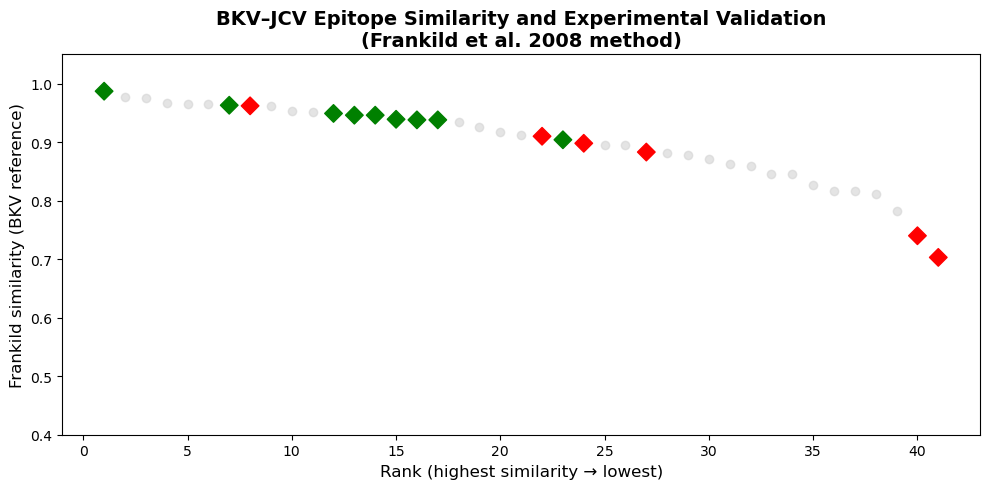

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your Frankild-based summary table
# Make sure you have a column "Frankild_S_BKV_ref" in this CSV
df = pd.read_csv("BKV_JCV_summary_table_Frankild.csv")

# Sort by Frankild score (highest first)
df = df.sort_values("BLOSUM similarity score", ascending=False).reset_index(drop=True)

# Add rank
df["Rank"] = df.index + 1

# Separate tested vs untested
df["Experimental_tested"] = df["Experimental_tested"].astype(str).str.strip().str.capitalize()
df["Experimental_outcome"] = df["Experimental_outcome"].astype(str).str.strip().str.capitalize()

tested = df[df["Experimental_tested"] == "Yes"]
untested = df[df["Experimental_tested"] == "No"]

# Assign colors for tested outcomes
colors = tested["Experimental_outcome"].map({
    "Positive": "green",
    "Negative": "red"
})

plt.figure(figsize=(10, 5))

# Untested pairs in gray
plt.scatter(
    untested["Rank"],
    untested["BLOSUM similarity score"],
    color="lightgray",
    alpha=0.6,
    label="Untested"
)

# Tested pairs (diamond markers, colored by outcome)
plt.scatter(
    tested["Rank"],
    tested["BLOSUM similarity score"],
    color=colors,
    s=80,
    marker="D",
    label="Tested (Positive/Negative)"
)

plt.xlabel("Rank (highest similarity → lowest)", fontsize=12)
plt.ylabel("Frankild similarity (BKV reference)", fontsize=12)
plt.title("BKV–JCV Epitope Similarity and Experimental Validation\n(Frankild et al. 2008 method)", 
          fontsize=14, fontweight="bold")
plt.ylim(0.4, 1.05)
plt.tight_layout()

plt.savefig("BKV_JCV_similarity_dotplot_Frankild.png", dpi=300)
plt.show()

In [4]:
import pandas as pd
from scipy.stats import fisher_exact

# Load Bresciani summary table
df = pd.read_csv("BKV_JCV_summary_table_Frankild.csv")

# Clean labels
df["Experimental_tested"] = df["Experimental_tested"].astype(str).str.strip().str.capitalize()
df["Experimental_outcome"] = df["Experimental_outcome"].astype(str).str.strip().str.capitalize()
df["Category"] = df["Category"].astype(str).str.strip()

# Filter only tested pairs
tested_df = df[df["Experimental_tested"] == "Yes"].copy()

# Collapse similarity categories: High + Moderate vs Low
tested_df["Similarity_group"] = tested_df["Category"].apply(
    lambda x: "High/Moderate" if x.startswith("High") or x.startswith("Moderate") else "Low"
)

# Build 2×2 contingency table
contingency_table = pd.crosstab(
    tested_df["Similarity_group"],
    tested_df["Experimental_outcome"],
    dropna=False
)

# Ensure full 2×2 structure
contingency_table = contingency_table.reindex(
    index=["High/Moderate", "Low"],
    columns=["Positive", "Negative"],
    fill_value=0
)

print("Contingency Table:\n", contingency_table)

# Fisher's Exact Test (association between similarity group and outcome)
oddsratio, p_value = fisher_exact(contingency_table)

print(f"\nOdds ratio: {oddsratio:.2f}")
print(f"Fisher's exact test p-value: {p_value:.4f}")

Contingency Table:
 Experimental_outcome  Positive  Negative
Similarity_group                        
High/Moderate                9         4
Low                          0         2

Odds ratio: inf
Fisher's exact test p-value: 0.1429


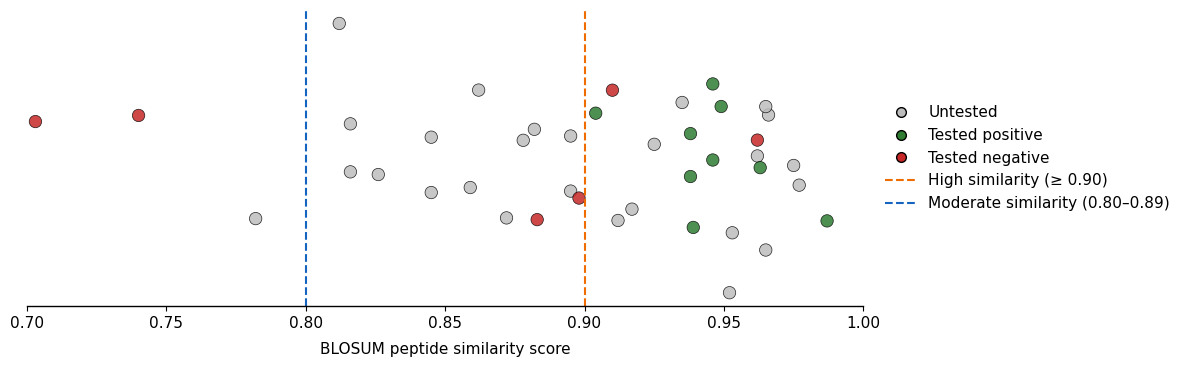

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ===============================
# Load data
# ===============================
df = pd.read_csv("BKV_JCV_summary_table_Frankild.csv")

df["Experimental_tested"] = df["Experimental_tested"].astype(str).str.strip().str.capitalize()
df["Experimental_outcome"] = df["Experimental_outcome"].astype(str).str.strip().str.capitalize()

# ===============================
# Color mapping (colorblind-friendly)
# ===============================
color_map = {
    ("Yes", "Positive"): "#2E7D32",   # dark green
    ("Yes", "Negative"): "#C62828",   # dark red
}

df["Color"] = df.apply(
    lambda r: color_map.get(
        (r["Experimental_tested"], r["Experimental_outcome"]),
        "#BDBDBD"  # untested (grey)
    ),
    axis=1
)

# ===============================
# Plot setup
# ===============================
plt.rcParams.update({
    "font.size": 11,
    "axes.linewidth": 1,
    "pdf.fonttype": 42,
    "ps.fonttype": 42
})

fig, ax = plt.subplots(figsize=(12, 3.8))

# Deterministic jitter
rng = np.random.default_rng(seed=42)
y_jitter = rng.normal(0, 0.04, size=len(df))

ax.scatter(
    df["BLOSUM similarity score"],
    y_jitter,
    c=df["Color"],
    s=80,
    alpha=0.85,
    linewidth=0.5,
    edgecolor="black"
)

# ===============================
# Threshold lines
# ===============================
ax.axvline(0.90, color="#EF6C00", linestyle="--", linewidth=1.5)
ax.axvline(0.80, color="#1565C0", linestyle="--", linewidth=1.5)

# ===============================
# Axes styling
# ===============================
ax.set_xlabel("BLOSUM peptide similarity score", labelpad=8)
ax.set_yticks([])
ax.set_xlim(0.7, 1.0)

# Remove unnecessary spines
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# ===============================
# Legend
# ===============================
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Untested',
           markerfacecolor='#BDBDBD', markeredgecolor='black', markersize=7),
    Line2D([0], [0], marker='o', color='w', label='Tested positive',
           markerfacecolor='#2E7D32', markeredgecolor='black', markersize=7),
    Line2D([0], [0], marker='o', color='w', label='Tested negative',
           markerfacecolor='#C62828', markeredgecolor='black', markersize=7),
    Line2D([0], [0], color='#EF6C00', linestyle='--', label='High similarity (≥ 0.90)'),
    Line2D([0], [0], color='#1565C0', linestyle='--', label='Moderate similarity (0.80–0.89)')
]

ax.legend(
    handles=legend_elements,
    frameon=False,
    loc="center left",
    bbox_to_anchor=(1.01, 0.5)
)

# ===============================
# Save
# ===============================
plt.tight_layout()
plt.savefig("BKV_JCV_Frankild_dotplot_publication.png", dpi=600, bbox_inches="tight")
plt.show()